#Introduction

Face recognition is one of the most common applications in the field of computer vision and artificial intelligence. This task involves a combination of three main steps: detecting faces in an image, extracting distinctive features, and classifying them. Modern systems operate by first locating a face in the image, then representing it through a numerical vector form called embedding, and finally passing this vector to a recognition algorithm.

This approach makes it possible to represent faces of different individuals in a feature space in such a way that vectors of the same person are located close to each other, while vectors of different individuals are further apart. In this way, the obtained embeddings become suitable for classical classification algorithms, such as Support Vector Machine (SVM), which can effectively separate the corresponding classes.

In this project, I needed to make algorithm to recognize five actors from the Avengers franchise. This dataset has pictures of Scarlet Johansson, Robert Downey Jr, Mark Ruffalo, Chris Evans and Chris Hemsworth. First I used FaceNet model to generate embeddings, then these embeddings are classified with a linear SVM. Also MTCNN helped with detecting face on testing images.

# Importing dataset

The first step was downloading and extracting the dataset that contains the facial images used for training and evaluation. Preparing and organizing data is considered a fundamental stage in any computer vision, since the quality and structure of the dataset have a direct influence on the performance of the algorithm. As emphasized in the literature, computer vision systems rely not only on the algorithms themselves but also on the reliability of the input data used to represent the visual problem.

Gdown package enables downloading files directly from Google Drive into the working environment.

In [1]:
!pip install gdown

In [2]:
!gdown --fuzzy -q https://drive.google.com/file/d/1poBLVBGNteXhgMVDO2vo9XxpXDsTeUK6/view

In [3]:
!unzip -q AVENGERS_FaceDetection.zip

#Installing MTCNN and DeepFace

The **Multi-task Cascaded Convolutional Neural Network (MTCNN)** is a method used for detecting faces with the help of deep learning. It works in three steps: the first step finds possible face regions, the second step removes false detections, and the third step improves the result by giving the exact face position and the main facial landmarks (eyes, nose, and mouth corners). This combination of detection and alignment makes MTCNN more accurate and reliable than older approaches such as Haar cascades or HOG-based methods.

**DeepFace** is an open-source library for Python that delivers face recognition. It includes a number of different models in deep learning techniques like VGG-Face, Facenet, ArcFace, and others. Deep face provides them with a single, simplified interface. This way, common face-related tasks like verification, recognition, and even analyzing attributes (age, gender, emotion, race) can be effortlessly done without requiring manual implementations.

A major plus of DeepFace is in wrapping different models so user can choose the one most suited for the task. So, DeepFace becomes so well accepted with the researchers as well as practical applications requiring face recognition.

In [5]:
!pip install mtcnn

In [4]:
!pip install deepface scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00


# Importing necessary libraries

In [50]:
import os
import numpy as np
import cv2
import dlib

from deepface import DeepFace

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.image as mpimg

 # Histogram of Oriented Gradients (HOG)

Besides MTCNN, I tried one of classical methods called  Histogram of Oriented Gradients (HOG). HOG is a feature descriptor that captures the distribution of gradient orientations in localized portions of an image, and it has historically been widely used for object and face detection due to its efficiency and simplicity.

The dlib implementation combines HOG features with a linear classifier to locate frontal faces in an image. While this approach performs well for upright, frontal faces in controlled conditions, it is significantly less robust when faces are rotated or presented in challenging lighting conditions.

I decided to add this segment because I wanted to compare HOG + dlib with MTCNN and why is so obvious that modern methods are used more. In further sections, I will present that practically.

Number of detected faces: 1


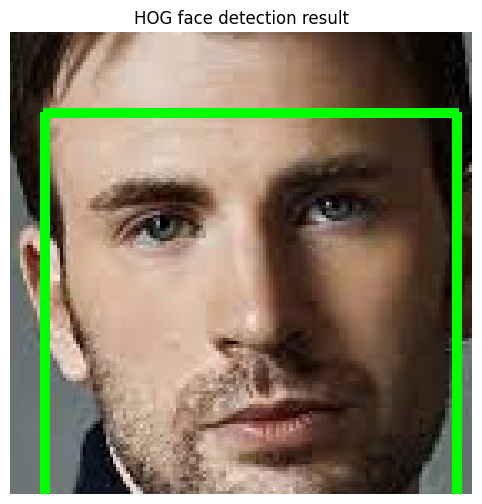

In [51]:
image = cv2.cvtColor(cv2.imread('cropped_images/chris_evans/chris_evans1.png'), cv2.COLOR_BGR2RGB)

hog = dlib.get_frontal_face_detector()

faces = hog(image, 0)
print("Number of detected faces:", len(faces))

for f in faces:
    left = f.left()
    top = f.top()
    right = f.right()
    bottom = f.bottom()
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

plt.figure(figsize=(8,6))
plt.imshow(image)
plt.axis('off')
plt.title("HOG face detection result")
plt.show()


#Implementing face embeddings and labeling dataset

**FaceNet** is a deep learning model developed for face recognition, verification, and clustering. Instead of directly classifying faces into predefined categories, FaceNet transforms each face into a compact numerical representation called an embedding. These embeddings are 128-dimensional vectors that capture the most discriminative features of a face.

The core idea behind FaceNet is to use a convolutional neural network (CNN) trained with the triplet loss function. FaceNet has become a foundation for many modern face recognition systems because of its efficiency and robustness.

First thing, cropped images of Avenger actors are used to generate embeddings. Then the loop iterates through all actor folders, where each folder corresponds to one class. The embeddings are then stored in the list and actor labels are stored in another list. After that, both lists are converted into arrays for further use. If an error occurs during processing, the image is skipped to ensure the dataset remains consistent.

In [15]:
dataset_path = "cropped_images"

X = []
Y = []

for actor in os.listdir(dataset_path):
    actor_folder = os.path.join(dataset_path, actor)
    if not os.path.isdir(actor_folder):
        continue
    for img_name in os.listdir(actor_folder):
        img_path = os.path.join(actor_folder, img_name)
        try:
            embedding = DeepFace.represent(
                img_path=img_path,
                model_name="Facenet",
                detector_backend="skip",
                enforce_detection=False
            )
            X.append(embedding[0]["embedding"])
            Y.append(actor)
        except Exception as e:
            print("Skipped image. Error:", img_path, e)

X = np.array(X)
Y = np.array(Y)


#Spliting into train and test set

In this step, embeddings and labels are divided into training and testing subsets using an 80/20 split, which is very common. Train-test splitting is a standard procedure in machine learning for assessing the generalization performance of models.

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

#Creating SVC

The **Support Vector Classifier** (SVC) is a machine learning algorithm based on **Support Vector Machines**(SVM). Its goal is to find the best boundary (called a hyperplane) that separates data points of different classes in a feature space. When a linear kernel is used, this boundary is a straight line (or hyperplane in higher dimensions), which works well when the data is already well separated, such as with FaceNet embeddings.

SVC is widely used in classification tasks because it is effective with high-dimensional data and can generalize well even with a limited number of training samples.

I decided to create SVC with a linear kernel and to train it on the embeddings from the training set. The linear kernel is chosen because the FaceNet embeddings are already well separated in the feature space, which makes linear decision boundaries sufficient for classification. The parameter probability=True allows the model to output probability estimates for each class.

For this use, the SVM classifier learns to distinguish between the embeddings of five different actors. By using the embeddings as input, the SVM effectively maps them to their corresponding actor labels, enabling accurate face recognition on new test images.

In [18]:
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

#Prediction on test set

Next phase is to make trained SVM to make predictions on the unseen data from the test set. The command applies the learned decision boundaries to the embeddings of the test imagesand assigns each sample to one of the predefined actor classes. I used this to show how well the model generalizes to new data, which is the key goal of supervised learning.

In [19]:
Y_pred = clf.predict(X_test)

#Model evaluation

The evaluation of the classifier is performed using the classification_report function, which provides several key metrics: precision, recall, F1-score, and support.


*   Precision measures how many of the predicted labels for a class are correct

*   Recall measures how many of the actual labels for a class are correctly identified by the model

*   F1-score is the harmonic mean of precision and recall, providing a balanced measure of both
*   Support represents the number of samples for each class in the test set

As its showed, the classifier achieved high performance across all actor classes. For almost every actor it reached perfect score in precision, recall, and F1-score, while the lowest values still indicate very strong performance. The overall accuracy confirms that the model generalizes well to unseen test images.

In [20]:
print(classification_report(Y_test, Y_pred))

                    precision    recall  f1-score   support

       chris_evans       0.91      1.00      0.95        10
   chris_hemsworth       1.00      0.91      0.95        11
      mark_ruffalo       1.00      1.00      1.00        13
  robert_downey_jr       1.00      1.00      1.00        10
scarlett_johansson       1.00      1.00      1.00        11

          accuracy                           0.98        55
         macro avg       0.98      0.98      0.98        55
      weighted avg       0.98      0.98      0.98        55



#Face detection of new image

The function face_detection integrates multiple steps of a face recognition pipeline. First, it generates a facial embedding from the input image using the Facenet model through the DeepFace framework. The detection of the facial area is performed with MTCNN, which provides both the bounding box and landmark localization. Using all of this, I ensured that the relevant facial region is properly aligned before recognition.

The extracted embedding is reshaped and passed to the trained Support Vector Classifier (SVC), which predicts the actor label. Additionally, the probability of the prediction is computed. A threshold value is supposed to label new imported images as "unknown", which reduces false positives.

Through function show_image=True, I wanted to represent the detected face by drawing a bounding box around it. Below picture it will display recognized actor and probability, so model can be validated.

In [40]:
def face_detection(image_path, clf, model_name="Facenet", threshold=0.8, show_image=True):
    try:
        embedding = DeepFace.represent(
            img_path=image_path,
            model_name=model_name,
            detector_backend="mtcnn",
            enforce_detection=False
        )[0]

        vector = np.array(embedding["embedding"]).reshape(1, -1)

        pred = clf.predict(vector)[0]
        prob = np.max(clf.predict_proba(vector))

        label = pred if prob >= threshold else "unknown"

        if show_image:
            img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            box = embedding["facial_area"]
            x = box["x"]
            y = box["y"]
            w = box["w"]
            h = box["h"]

            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            plt.imshow(img)
            plt.axis("off")
            plt.show()

            print(f"Actor on imported picture: {label}, confididence: {prob:.2%}")

    except Exception as e:
        print("Error:", e)
        return None, 0

#Importing test images for all 5 actors

In this part of project, I wanted to upload different test pictures of every Avengers actor, along with one picture of Theo James to check if model really do recognize well. I made sure pictures are in various orientation and quality. Visual inspection of these inputs is important and ensures that the images are properly read into memory. It allows the identification of potential preprocessing issues before applying the recognition function.

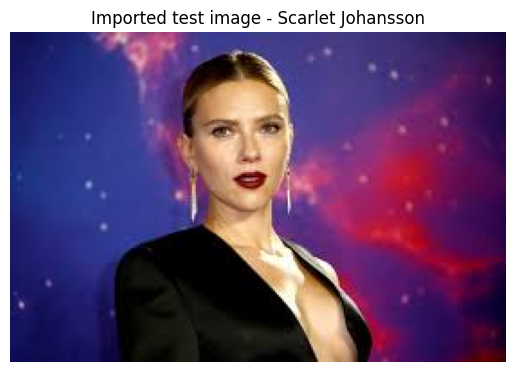

In [30]:
test_sj = "scarlet.jpeg"
img_sj = mpimg.imread(test_sj)

plt.imshow(img_sj)
plt.axis("off")
plt.title("Imported test image - Scarlet Johansson")
plt.show()

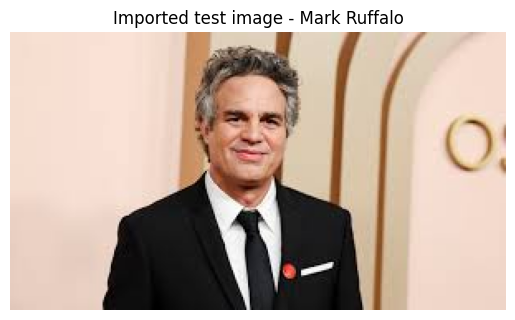

In [35]:
test_mr = "mark.jpeg"
img_mr = mpimg.imread(test_mr)

plt.imshow(img_mr)
plt.axis("off")
plt.title("Imported test image - Mark Ruffalo")
plt.show()

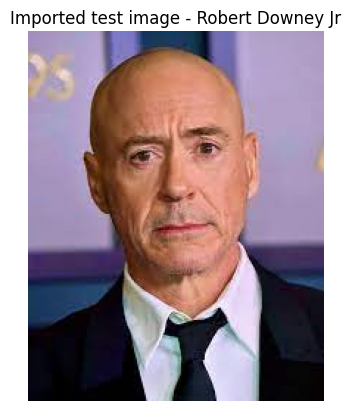

In [26]:
test_r = "robert.jpeg"
img_r = mpimg.imread(test_r)

plt.imshow(img_r)
plt.axis("off")
plt.title("Imported test image - Robert Downey Jr")
plt.show()

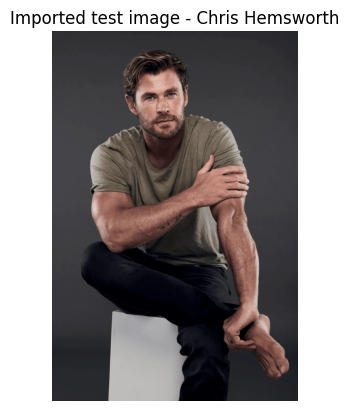

In [27]:
test_ch = "chris.webp"
img_ch = mpimg.imread(test_ch)

plt.imshow(img_ch)
plt.axis("off")
plt.title("Imported test image - Chris Hemsworth")
plt.show()

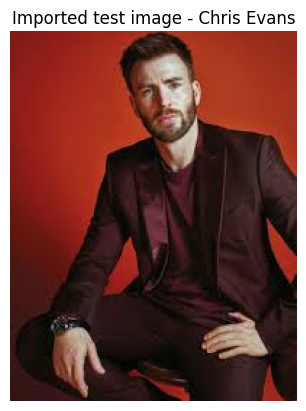

In [28]:
test_ce = "evans.jpeg"
img_ce = mpimg.imread(test_ce)

plt.imshow(img_ce)
plt.axis("off")
plt.title("Imported test image - Chris Evans")
plt.show()

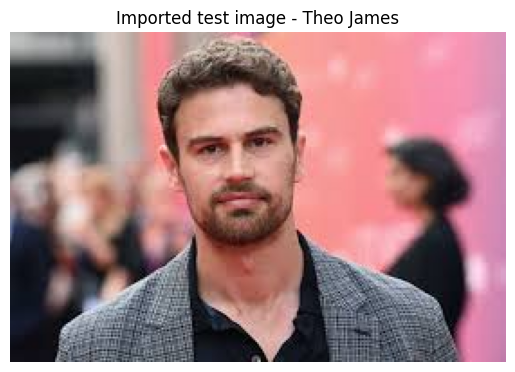

In [47]:
test_tj = "theo james.jpeg"
img_tj = mpimg.imread(test_tj)

plt.imshow(img_tj)
plt.axis("off")
plt.title("Imported test image - Theo James")
plt.show()

#Testing face recognition

And here are the results.

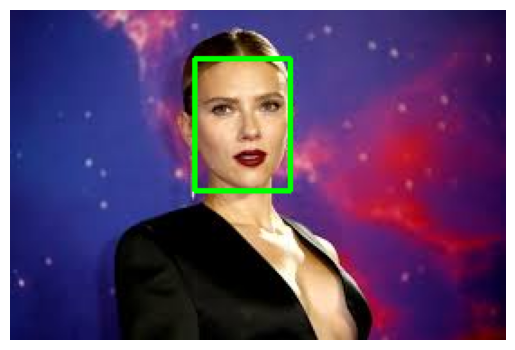

Actor on imported picture: scarlett_johansson, confididence: 94.75%


In [41]:
face_detection(test_sj, clf)

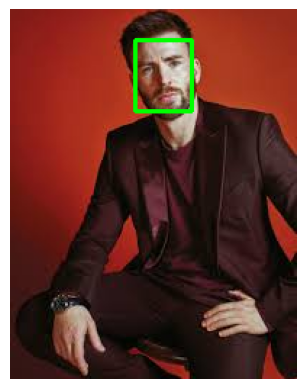

Actor on imported picture: chris_evans, confididence: 92.02%


In [42]:
face_detection(test_ce, clf)

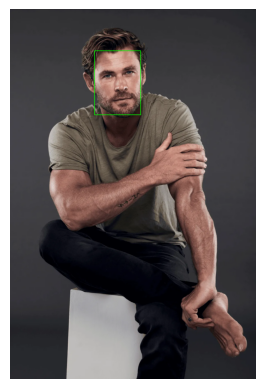

Actor on imported picture: chris_hemsworth, confididence: 88.45%


In [43]:
face_detection(test_ch, clf)

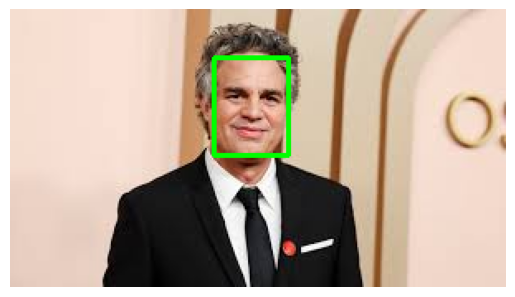

Actor on imported picture: mark_ruffalo, confididence: 90.50%


In [44]:
face_detection(test_mr, clf)

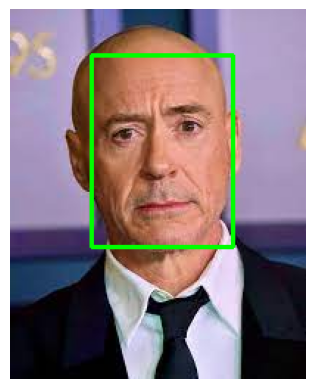

Actor on imported picture: robert_downey_jr, confididence: 96.31%


In [45]:
face_detection(test_r, clf)

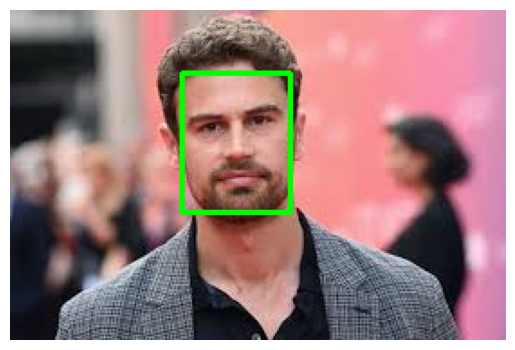

Actor on imported picture: unknown, confididence: 77.60%


In [48]:
face_detection(test_tj, clf)

#Conclusion

Face detection is a key technology in the field of artificial intelligence with many practical applications, including security, biometrics, law enforcement, and entertainment.

I tried a range of methods, one included in this project, and I chose MTCNN, Facenet, along with SVC because it gave me the best outcome. It showed very powerful results and strong prediction for Avangers dataset. MTCNN, as a modern face detection network, provided high accuracy and gave really good face detection in pictures. Enbedding generated by Facenet is very advanced and well-suited in combination with SVM, eventhough this dataset is relatively small.

Working on this project, I learned basic concepts of face recognition algorithms which was very interesting and insightful. While exploring how can I deal with this problem I realized how quality of dataset is important and how there are so many different solutions. In overall score, I think I will try to experiment with face recognition using different principles and approaches to expand my knowledge.